Importing the required libraries.

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


The following cell downloads the data and sets key variables.

In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

Cell 3: Data Generators
Purpose: Set up ImageDataGenerator pipelines to load and preprocess images.

Key Actions:

Rescales pixel values (0–255 → 0–1).

Uses flow_from_directory to:

Load images from train/, validation/, and test/ folders.

Assign labels automatically (binary: cat=0, dog=1).

For test data: shuffle=False to preserve order.

In [3]:
# 3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 128 using train_image_generator generator
train_data_gen = train_image_generator.flow_from_directory(
        batch_size=128,
        directory=train_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode='binary')

# Flow validation images in batches of 128 using validation_image_generator generator
validation_data_gen = validation_image_generator.flow_from_directory(
        batch_size=128,
        directory=validation_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode='binary')

# Flow test images in batches of 20 using test_image_generator generator
test_data_gen = test_image_generator.flow_from_directory(
        batch_size=20,
        directory=test_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        classes=[''],
        class_mode=None,
        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


Cell 4: Sample Training Images
Purpose: Visualize 5 random training images using plotImages().

Confirms: Data generators work correctly.

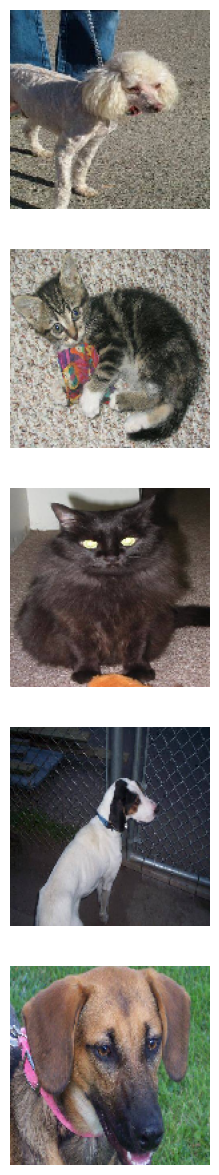

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


Cell 5: Data Augmentation
Purpose: Enhance training data with random transformations to reduce overfitting.

Techniques Added:

Rotation, shifts, shear, zoom, flip.

Keeps original rescaling (1./255).

In [5]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Cell 6: Augmented Samples
Purpose: Show the same image after 5 random augmentations.

Confirms: Augmentation works as expected.

Found 2000 images belonging to 2 classes.


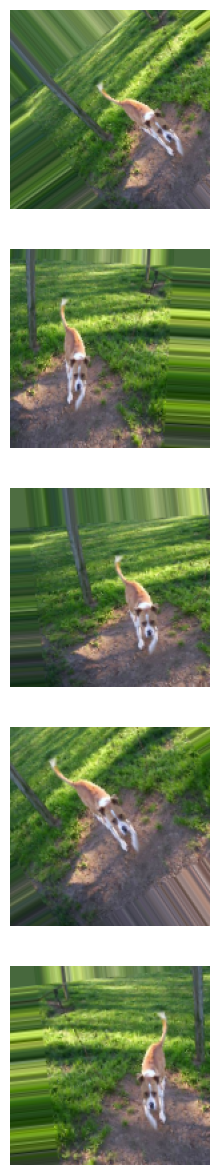

In [6]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

Cell 7: Model Architecture
Purpose: Define the CNN model.

Layers:

3x Conv2D + MaxPooling2D blocks (feature extraction).

Flatten + Dense(512, ReLU) (fully connected).

Output: Dense(1, sigmoid) (binary classification).

Compiled with:

Optimizer: adam.

Loss: binary_crossentropy.

Metric: accuracy.

In [7]:
# 7
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Cell 8: Training
Purpose: Train the model.

Key Parameters:

steps_per_epoch: Batches per epoch (total_train // batch_size).

validation_steps: Batches for validation.

epochs=15 (adjustable).

In [9]:
#8
import os

total_train = len(os.listdir(os.path.join(train_dir, 'cats'))) + len(os.listdir(os.path.join(train_dir, 'dogs')))
total_validation = len(os.listdir(os.path.join(validation_dir, 'cats'))) + len(os.listdir(os.path.join(validation_dir, 'dogs')))
batch_size = 128

history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=15,
    validation_data=validation_data_gen,
    validation_steps=total_validation // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 130s 8s/step - accuracy: 0.5072 - loss: 1.1931 - val_accuracy: 0.5022 - val_loss: 0.6905
Epoch 2/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:21 6s/step - accuracy: 0.5078 - loss: 0.6911

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5078 - loss: 0.6911 - val_accuracy: 0.5123 - val_loss: 0.6876
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.5207 - loss: 0.6934 - val_accuracy: 0.5201 - val_loss: 0.6774
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5078 - loss: 0.6784 - val_accuracy: 0.5011 - val_loss: 0.6811
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 202s 12s/step - accuracy: 0.5301 - loss: 0.6843 - val_accuracy: 0.5156 - val_loss: 0.6800
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5156 - loss: 0.6744 - val_accuracy: 0.5402 - val_loss: 0.6693
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.5849 - loss: 0.6675 - val_accuracy: 0.5569 - val_loss: 0.6536
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6172 - loss: 0.6403 - val_accuracy: 0.5703 - val_loss: 0.6484
Epoch 9/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - accuracy: 0.5983 - loss: 0.6513 - val_accuracy: 0.6529 - val_loss: 0.6

Cell 9: Performance Plots
Purpose: Plot training vs validation accuracy/loss over epochs.

Shows: Overfitting or convergence trends.

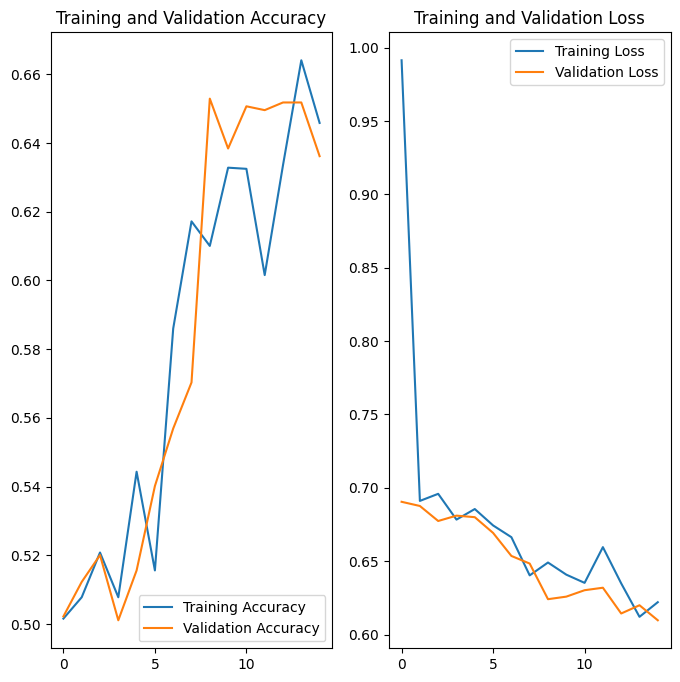

In [10]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Cell 10: Predictions
Purpose: Classify test images and visualize results.

Steps:

Load/test images (rescaled to 0–1).

Predict probabilities (0=cat, 1=dog).

Plot images with predicted labels (% confidence).

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


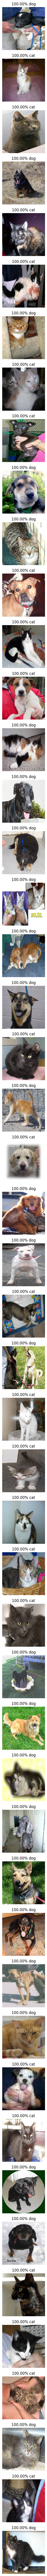

In [12]:
# 10
import numpy as np
from tensorflow.keras.preprocessing import image

# Get the test image filepaths
test_filenames = [os.path.join(test_dir, fname) for fname in test_data_gen.filenames]

# Load and preprocess each test image
test_images = []
for img_path in test_filenames:
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Rescale to [0,1]
    test_images.append(img_array)

# Convert to numpy array
test_images = np.array(test_images)

# Get predictions
probabilities = model.predict(test_images)
probabilities = [1 if prob > 0.5 else 0 for prob in probabilities]

# Plot the images with predictions
plotImages(test_images, probabilities)

Cell 11: Submission Check
Purpose: Validates if accuracy ≥63% (freeCodeCamp requirement).

Output: "You passed!" or "Keep trying."

In [13]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!
